# Building a RAG application from scratch!
[system2.png](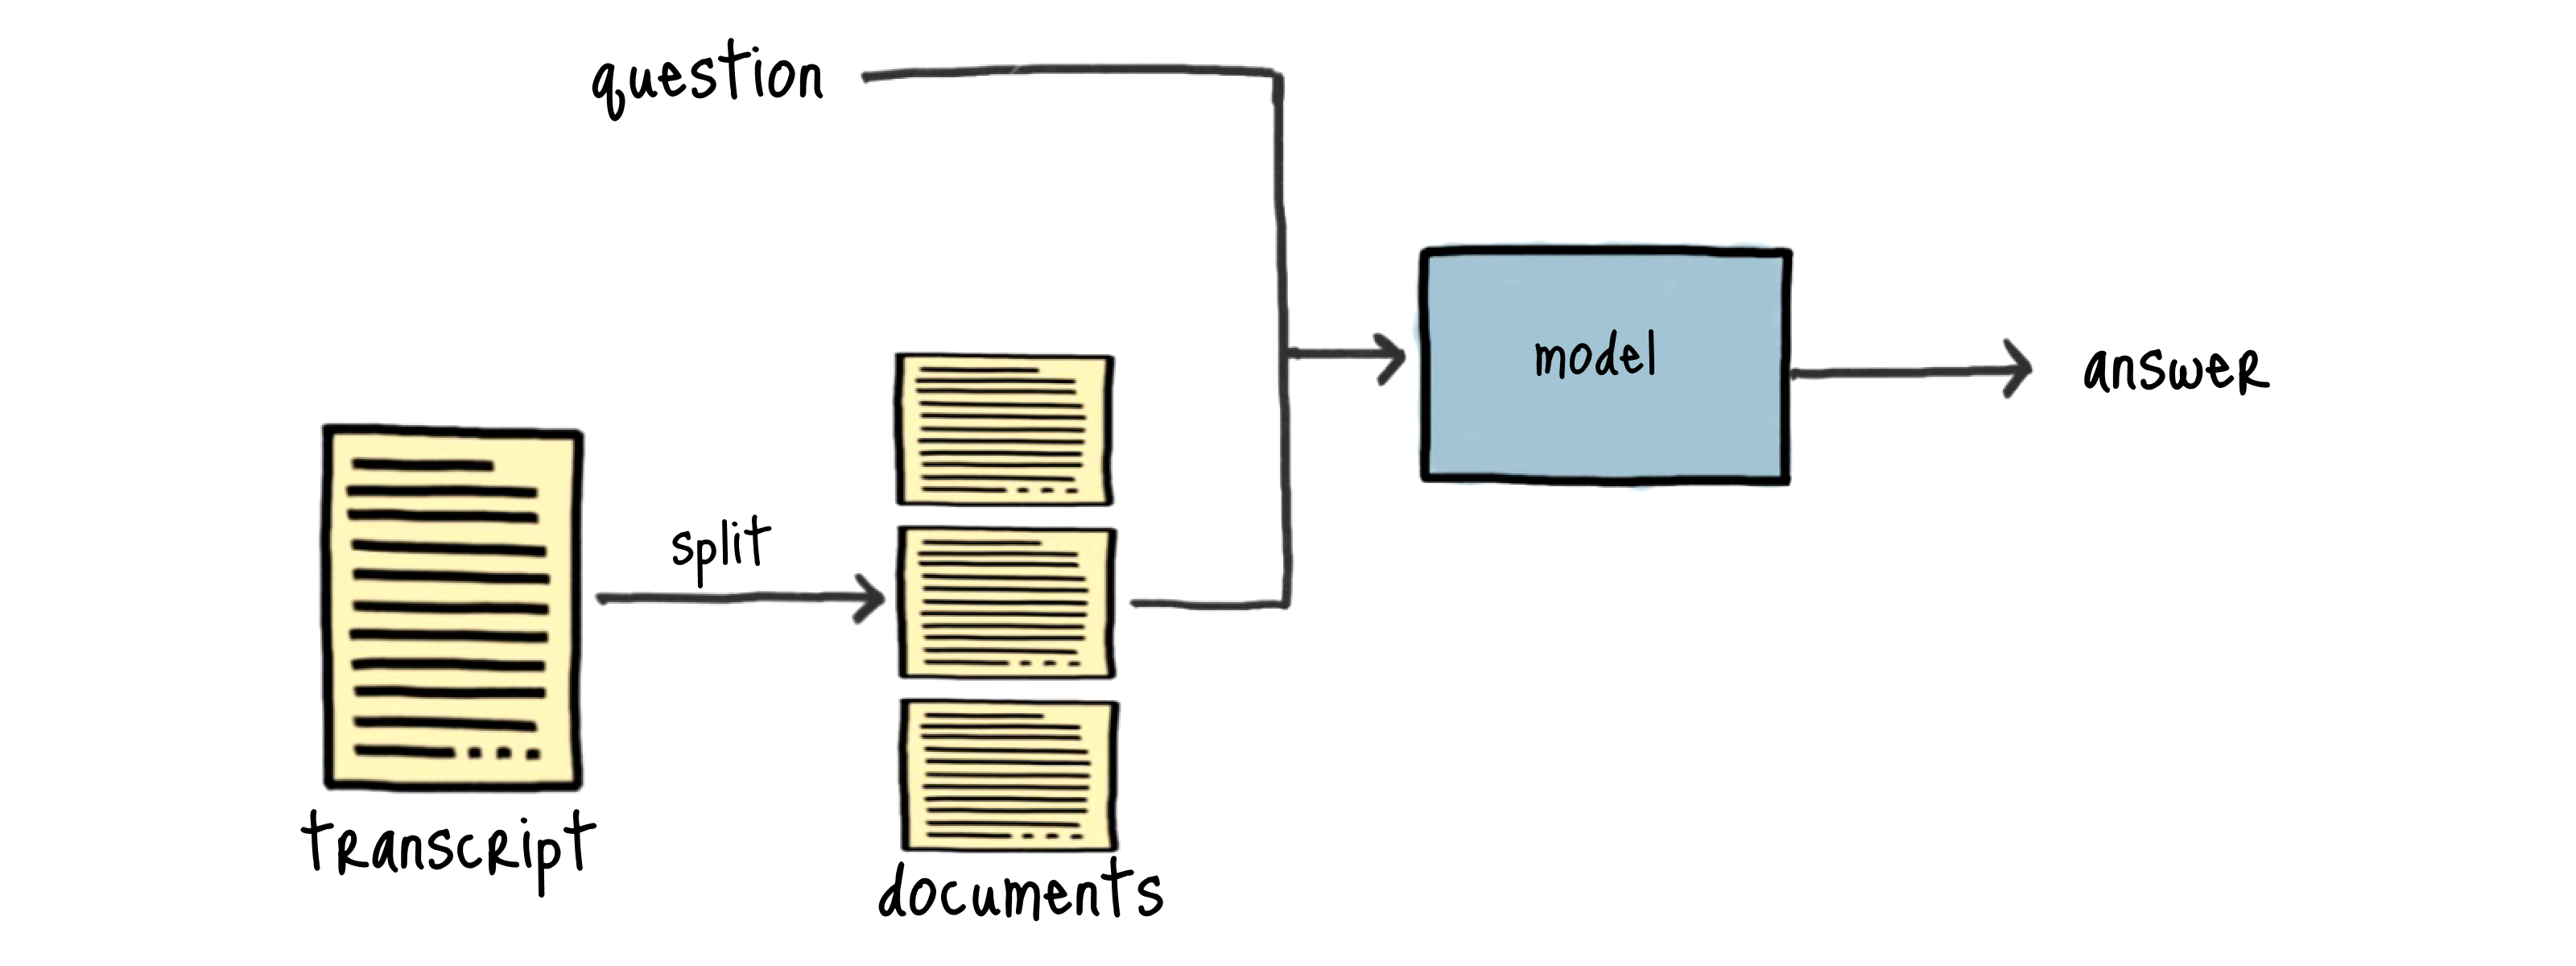![efdafdfdgdfgf.jpg](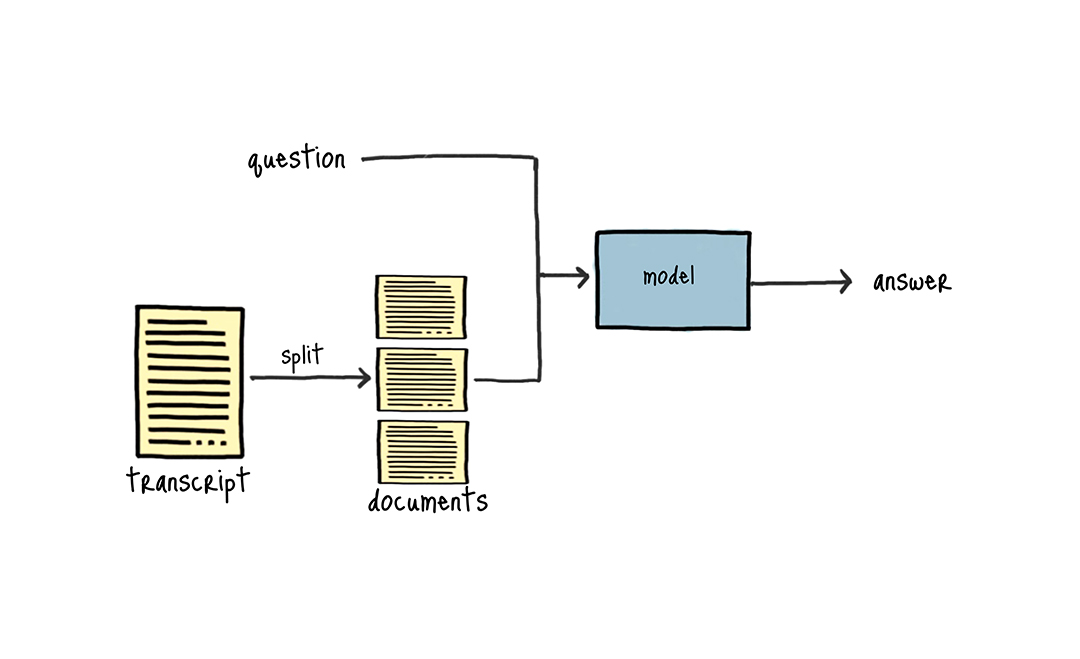![system2.png](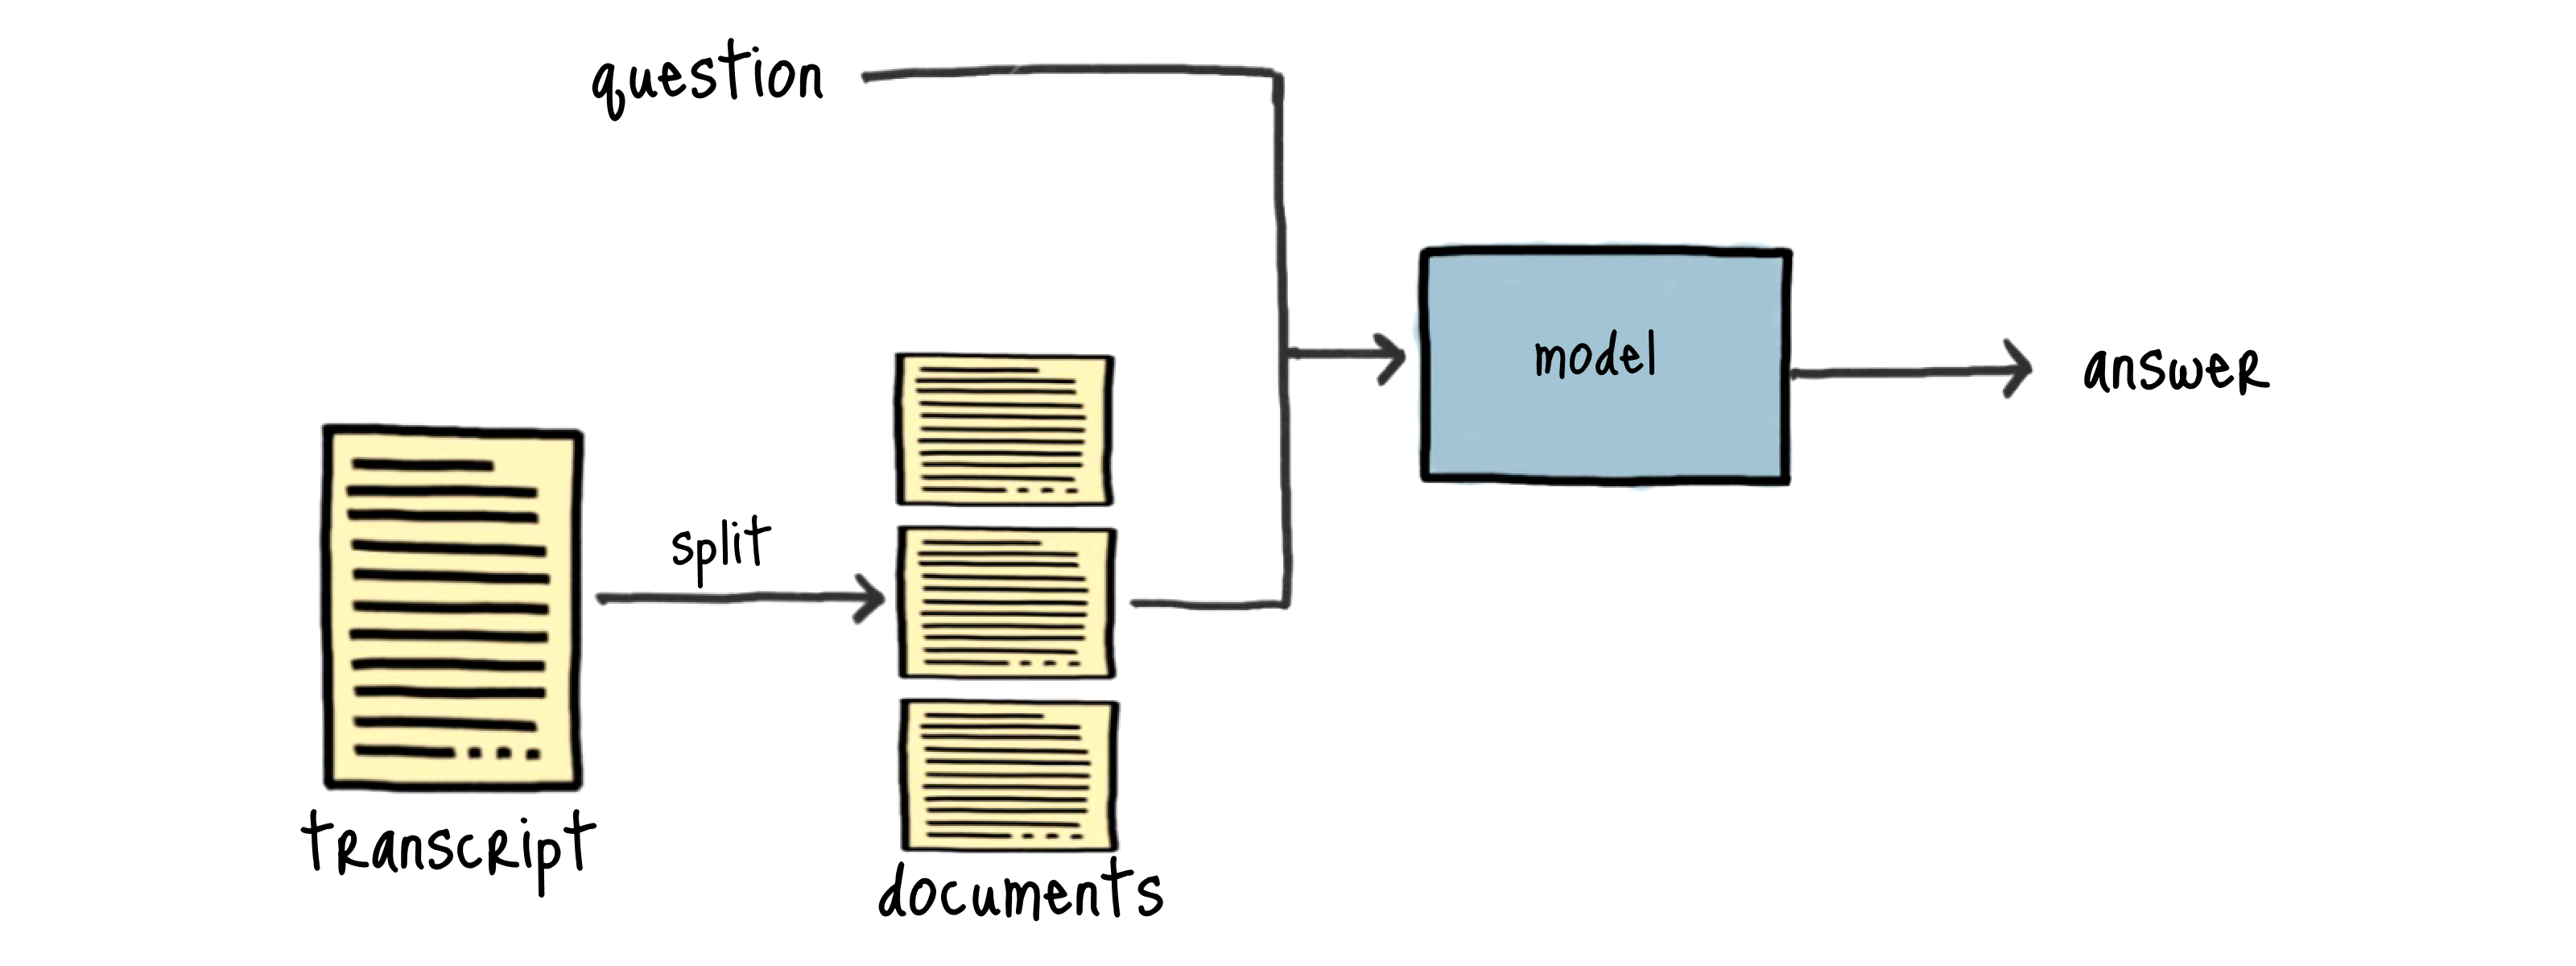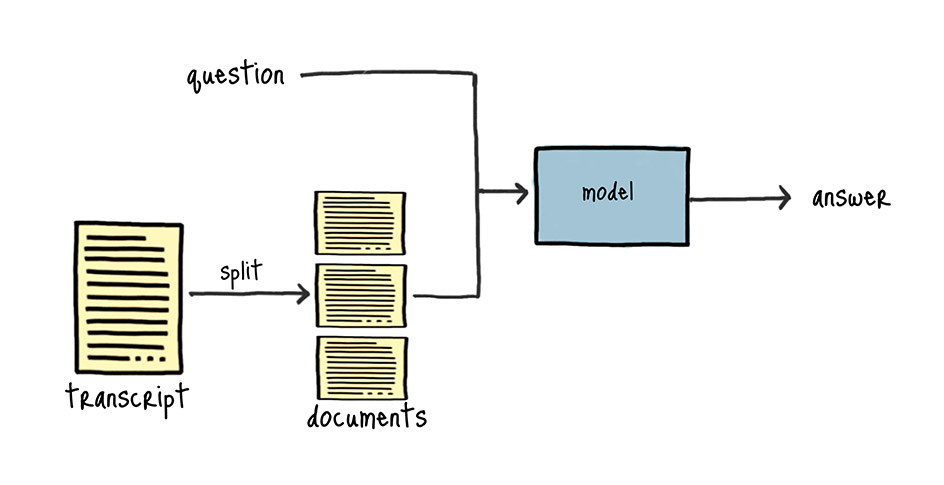)))
Here is a high-level overview of the system we want to build:


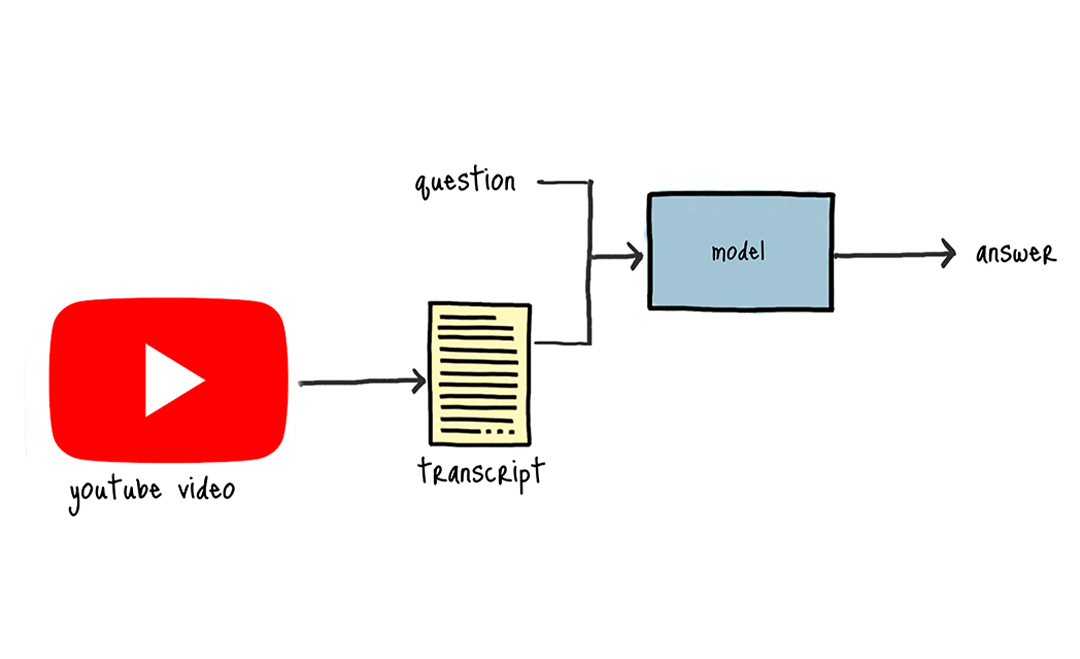

In [ ]:
!pip install langchain langchain-openai langchain_pinecone langchain[docarray] docarray pydantic==1.10.8 pytube python-dotenv tiktoken pinecone-client scikit-learn ruff whisper
!pip install git+https://github.com/openai/whisper.git
!pip install langchain_community

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-ibo5gsk8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-ibo5gsk8
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [ ]:
# Let's start by loading the environment variables we need to use.

import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# This is the YouTube video we're going to use.
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=67VFKokHA7o&ab_channel=TheDr.GundryPodcast"

# Setting up the model
Let's define the LLM model that we'll use as part of the workflow.

In [ ]:
from langchain_openai.chat_models import ChatOpenAI
OPENAI_API_KEY = 'Your API key'

model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-3.5-turbo")

# Transcribing the YouTube Video
The context we want to send the model comes from a YouTube video. Let's download the video and transcribe it using OpenAI's Whisper.

In [ ]:
import tempfile
import whisper
from pytube import YouTube


# Let's do this only if we haven't created the transcription file yet.
if not os.path.exists("transcription.txt"):
    youtube = YouTube(YOUTUBE_VIDEO)
    audio = youtube.streams.filter(only_audio=True).first()

    # Let's load the base model. This is not the most accurate
    # model but it's fast.
    whisper_model = whisper.load_model("base")

    with tempfile.TemporaryDirectory() as tmpdir:
        file = audio.download(output_path=tmpdir)
        transcription = whisper_model.transcribe(file, fp16=False)["text"].strip()

        with open("transcription.txt", "w") as file:
            file.write(transcription)

Let's read the transcription and display the first few characters to ensure everything works as expected.

In [ ]:
with open("transcription.txt") as file:
    transcription = file.read()

transcription[:400]

"Welcome to the Dr. Gundry Podcast. One in every nine men develop prostate cancer during their lifetime. One in nine guys, listen up. And unfortunately, prostate cancer is the second leading cause of cancer deaths for men in the United States. So whether you're a man or a woman, pay attention. What we're about to share could help save someone you love, maybe even you. That's right. My guest today s"

#Splitting the transcription

Since we can't use the entire transcription as the context for the model, a potential solution is to split the transcription into smaller chunks. We can then invoke the model using only the relevant chunks to answer a particular question:


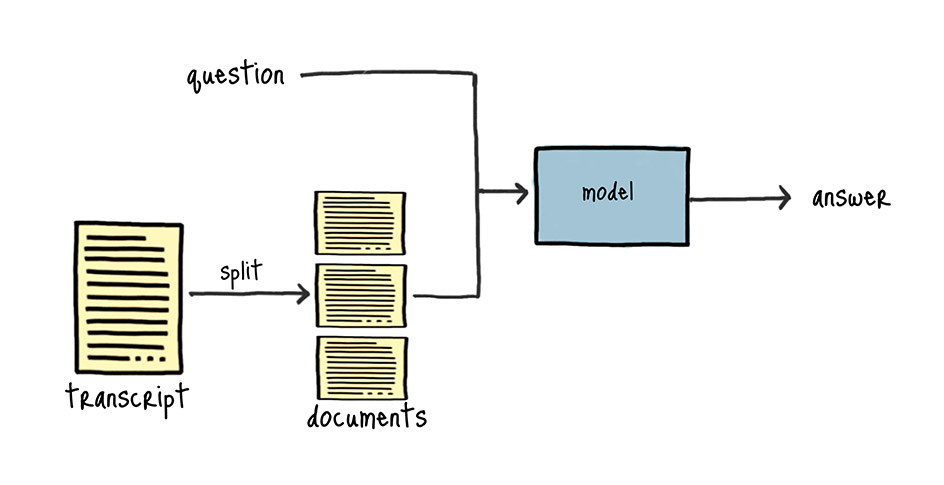

Let's start by loading the transcription in memory:

In [ ]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("transcription.txt")
text_documents = loader.load()
text_documents

[Document(page_content="Welcome to the Dr. Gundry Podcast. One in every nine men develop prostate cancer during their lifetime. One in nine guys, listen up. And unfortunately, prostate cancer is the second leading cause of cancer deaths for men in the United States. So whether you're a man or a woman, pay attention. What we're about to share could help save someone you love, maybe even you. That's right. My guest today says that there are plenty of ways for men to take charge of their prostate health now and greatly reduce their chance of facing serious health issues down the line. He's Dr. Mark Stingler, a naturopathic medical doctor who was recently named Doctor of the Decade by the International Association of Top Professionals. Dr. Stingler is also the author of many bestselling books, including his latest release, Healing the Prostate, the best holistic methods to treat the prostate and other common male-related conditions. Today, Dr. Stingler and I are going to discuss the root c

There are many different ways to split a document. For this example, we'll use a simple splitter that splits the document into chunks of a fixed size. Check Text Splitters for more information about different approaches to splitting documents.

For illustration purposes, let's split the transcription into chunks of 100 characters with an overlap of 20 characters and display the first few chunks:

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
text_splitter.split_documents(text_documents)[:5]

[Document(page_content='Welcome to the Dr. Gundry Podcast. One in every nine men develop prostate cancer during their', metadata={'source': 'transcription.txt'}),
 Document(page_content='cancer during their lifetime. One in nine guys, listen up. And unfortunately, prostate cancer is', metadata={'source': 'transcription.txt'}),
 Document(page_content='prostate cancer is the second leading cause of cancer deaths for men in the United States. So', metadata={'source': 'transcription.txt'}),
 Document(page_content="United States. So whether you're a man or a woman, pay attention. What we're about to share could", metadata={'source': 'transcription.txt'}),
 Document(page_content="to share could help save someone you love, maybe even you. That's right. My guest today says that", metadata={'source': 'transcription.txt'})]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(text_documents)

# Loading transcription into the vector store

We initialized the vector store with a few random strings. Let's create a new vector store using the chunks from the video transcription.

In [ ]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough

# Create OpenAIEmbeddings instance with the API key
embeddings = OpenAIEmbeddings(openai_api_key="Your APi Key")

vectorstore1 = DocArrayInMemorySearch.from_documents(documents, embeddings)

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """
Answer the question based on the context below. If you can't
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

In [ ]:
chain = (
    {"context": vectorstore2.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)
chain.invoke("What is the cause of prostate cancer?")

'The cause of prostate cancer can be related to factors such as insulin resistance, diabetes, and prolonged high levels of the hormone insulin, as well as the growth response on prostate cells. Additionally, vitamin D receptors on prostate cells have been identified as playing a role in prostate health and potentially in the development of prostate cancer.'

# Setting up Pinecone

The first step is to create a Pinecone account, set up an index, get an API key, and set it as an environment variable `PINECONE_API_KEY`.

Then, we can load the transcription documents into Pinecone:

In [ ]:
from langchain_pinecone import PineconeVectorStore
import os

# Set the API key as an environment variable
os.environ["PINECONE_API_KEY"] = "Your APi key"

index_name = "youtube-rag-index"

Pinecone = PineconeVectorStore.from_documents(
    documents, embeddings, index_name=index_name
)

In [ ]:
Pinecone.similarity_search("How can we prevent prostate cancer?")[:3]

[Document(page_content="But when you actually break down the breakdown of all these people, if you actually ate a lot of fish, had a glass of red wine and took a baby aspirin, these people actually immune from prostate cancer in this study group. That of course didn't make the news because that isn't very exciting. That was actually what should have been the conclusion of that study. We have to be careful with what the news media thinks is interesting about a study. Yeah, a very, very good point. Yeah, I use omega-3 index too with our quest labs. Probably like you, it's amazing. It's kind of like vitamin D. How many people come out low on the omega-3 index? Yeah, very true. One other thing that I think you ought to bring up, where do you think lig nands that fall into all of this? Yes, thank you for asking. I'm a big fan of ground up flax seeds and the lig nands you get in flax seeds. There's some preliminary, not conclusive evidence that they do have a protective effect against prosta

Let's setup the new chain using Pinecone as the vector store:

In [ ]:
chain = (
    {"context": Pinecone.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

chain.invoke("How can we prevent prostate cancer?")

'We can prevent prostate cancer by incorporating a healthy diet rich in plant foods, engaging in regular exercise, maintaining a healthy weight, addressing nutritional deficiencies, and possibly using supplements like lignands from ground up flax seeds. Omega-3 fatty acids from fish, a glass of red wine, and baby aspirin may also contribute to preventing prostate cancer.'